In [19]:
from PIL import Image
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

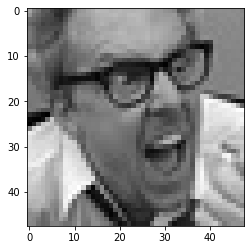

In [24]:
def load_image_tensor(filepath):
    img = Image.open(filepath)
    transform = transforms.Compose([
        transforms.PILToTensor()
    ])
    img_tensor = transform(img)

    return img_tensor

img = load_image_tensor("Face/train/angry/Training_3908.jpg").reshape(48, 48)
plt.imshow(img,cmap="gray")

In [45]:
Image_list = []
Label_list = []
label_dic = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprise":6,}
for folder in os.listdir("Face"):
    for label in os.listdir("Face/"+folder):
        for image in os.listdir("Face/"+folder+"/"+label):
            Image_list.append("Face/"+folder+"/"+label+"/"+image)
            Label_list.append(label_dic[label])
            
Image_df = pd.DataFrame(Image_list,columns=["Image Path"])
Label_df = pd.DataFrame(Label_list,columns=["Label"])
Dataset_df = pd.concat([Image_df,Label_df],axis=1)

In [47]:
from torch.utils.data import Dataset

class FERDataset(Dataset):
    def __init__(self, dataset_df): 
        super().__init__()
        self.dataframe = dataset_df[:35880]
        
    def __len__(self):
        return len(self.dataframe) 
        
    def __getitem__(self, i):
        return self.dataframe.iloc[i] 

In [48]:
import multiprocessing as mp
from torch.utils.data import DataLoader, random_split

def custom_collate_fn(batch):
    image_batch_tensor = torch.FloatTensor(len(batch), 48, 48)  
    image_tensors = []
    labels = []
    for item in batch:
        image_tensor = load_image_tensor(item[0]) 
        image_tensors.append(image_tensor)
        labels.append(item[1]) 


    torch.cat(image_tensors, out=image_batch_tensor)  
    label_batch_tensor = torch.LongTensor(labels) 
    return (image_batch_tensor, label_batch_tensor)


def load_data(dataset_df, batch_sz=100, train_val_test_split=[0.3, 0.2, 0.5]):
    
    assert sum(train_val_test_split) == 1, "Train, val and test fractions should sum to 1!"  
    dataset = FERDataset(dataset_df)  
    
    tr_va_te = []
    for frac in train_val_test_split:
        actual_count = frac * len(dataset)
        actual_count = round(actual_count)
        tr_va_te.append(actual_count)
    
    # split dataset into train, val and test
    train_split, val_split, test_split = random_split(dataset, tr_va_te)
    
    
    n_cpus = mp.cpu_count() # returns number of CPU cores on this machine
    train_dl = DataLoader(train_split, 
                          batch_size=batch_sz, 
                          shuffle=True, 
                          collate_fn=custom_collate_fn,
                          num_workers=n_cpus)            
    val_dl = DataLoader(val_split, 
                        batch_size=batch_sz, 
                        shuffle=True, 
                        collate_fn=custom_collate_fn,
                        num_workers=n_cpus)
    test_dl = DataLoader(test_split,
                         batch_size=batch_sz,
                         shuffle=False,
                         collate_fn=custom_collate_fn,
                         num_workers=n_cpus)
    return train_dl, val_dl, test_dl


In [70]:
train_dl, val_dl, test_dl = load_data(Dataset_df, batch_sz=64)

In [71]:
def image_grid(batch, ncols=4):
    height, width = batch[0].shape
    nrows = len(batch)//ncols # calculate the number of rows based on the number of columns needed by the user
    
    img_grid = (batch.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    
    return img_grid


def show_batch(batch, title="Image batch", cols=4):
    N = len(batch)
    if N > cols:
        assert N % cols == 0, "Number of cols must be a multiple of N"
    
    result = image_grid(batch)
    fig = plt.figure(figsize=(5., 5.))
    plt.suptitle(f"{title} [{int(N/cols)}x{cols}]")
    plt.imshow(result, cmap='gray')

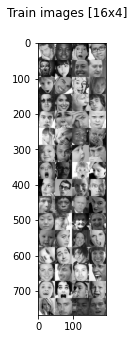

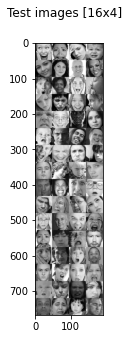

In [72]:
train_images, _ = next(iter(train_dl))
test_images, _ = next(iter(test_dl))

show_batch(train_images, title="Train images", cols=4)
show_batch(test_images, title="Test images", cols=4)

In [54]:
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn 
from torchsummary import summary

In [75]:
def get_simple_linear_net():
    return nn.Sequential(
        nn.Flatten(),               
        nn.Linear(48*48, 24*48),
        nn.ReLU(),                  
        nn.Linear(24*48, 24*24),  
        nn.ReLU(),                  
        nn.Linear(24*24, 12*24),
        nn.ReLU(),                  
        nn.Linear(12*24, 128),  
        nn.ReLU(),                  
        nn.Linear(128, 7)  
        
    )

summary(get_simple_linear_net(), input_size=(1, 48, 48), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 2304]               0
            Linear-2                 [-1, 1152]       2,655,360
              ReLU-3                 [-1, 1152]               0
            Linear-4                  [-1, 576]         664,128
              ReLU-5                  [-1, 576]               0
            Linear-6                  [-1, 288]         166,176
              ReLU-7                  [-1, 288]               0
            Linear-8                  [-1, 128]          36,992
              ReLU-9                  [-1, 128]               0
           Linear-10                    [-1, 7]             903
Total params: 3,523,559
Trainable params: 3,523,559
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 13.44
Estima

In [76]:
def train_model_gpu_lr(model, epochs, train_dl, optimiser, lr_scheduler):
    msg = ""
    for epoch in range(epochs):
        total_steps = len(train_dl)
        correct = 0
        total = 0

        model.train()
        for batch_num, (image_batch, label_batch) in enumerate(train_dl):
            batch_sz = len(image_batch)
            
            image_batch = image_batch
            label_batch = label_batch
            
            output = model(image_batch)
            losses = nn.CrossEntropyLoss()(output, label_batch)
                        
            optimiser.zero_grad()
            losses.backward()
            optimiser.step()  
            
            preds = torch.argmax(output, dim=1)
            correct += int(torch.eq(preds, label_batch).sum())
            total += batch_sz
            minibatch_accuracy = 100 * correct / total

            #### Fancy printing stuff, you can ignore this! ######
            if (batch_num + 1) % 5 == 0:
                print(" " * len(msg), end='\r')
                msg = f'Train epoch[{epoch+1}/{epochs}], MiniBatch[{batch_num + 1}/{total_steps}], Loss: {losses.item():.5f}, Acc: {minibatch_accuracy:.5f}, LR: {lr_scheduler.get_last_lr()[0]:.5f}'
                print (msg, end='\r' if epoch < epochs else "\n",flush=True)

In [78]:
from torch.optim import SGD

# Defining network hyperparameters
epochs = 50
learning_rate = 0.005

network = get_simple_linear_net()                    # Creating an instance of our network
optim = SGD(network.parameters(), lr=learning_rate)  # Stochastic gradient descent optimiser
lr_sch = ExponentialLR(optim, gamma=0.5)
train_model_gpu_lr(network, epochs, train_dl, optim, lr_sch) 

In [79]:
train_model_gpu_lr(network, epochs, train_dl, optim, lr_sch) 